# Baseline Model - Ensemble Models

In [1]:
# libraries
import pandas as pd
import numpy as np
from pyproj import Geod
import json

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# connect to data source
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import data
df_path = '/content/drive/MyDrive/CapstoneProject/ryanair_clean_datasets/train_extended.csv'
df = pd.read_csv(df_path)

In [4]:
# Remove data registered after arrival
df = df.drop(['ActualRoute','DepartureActual', 'ArrivalActual', 'BlockTime', 'TaxiOut', 'FlightTime'], axis=1)

# Drop irrelavant columns
df = df.drop(['FlightID', 'FlightNumber', 'AircraftRegistration', 'ServiceDescription', 'Carrier', 'AOCDescription', 'ScheduledRoute',
              'DepartureScheduled', 'ArrivalScheduled'], axis=1)

# Remove negative burnoff
df = df[df["Burnoff"] > 0]

In [5]:
df.columns

Index(['AircraftCapacity', 'AircraftTypeGroup', 'BlockTimeScheduled',
       'Burnoff', 'Adults', 'Children', 'Freight', 'Infants', 'Bags',
       'PlannedZeroFuelWeight', 'PlannedTOW', 'PlannedTripTime',
       'TeledyneRampWeight'],
      dtype='object')

In [6]:
# Reduce dimensions of data due to computing constraints for ensemble models
df = df.tail(100000)

In [7]:
# Split the data into train and test
X = df.drop(labels=['Burnoff'], axis=1)
y = df['Burnoff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [8]:
# Define the preprocessor
categorical_columns = ["AircraftTypeGroup"]
numerical_columns = [col for col in X.columns if col not in categorical_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OrdinalEncoder(), categorical_columns),
        ("numerical", StandardScaler(), numerical_columns),
    ]
)

In [9]:
def best_model(X_train, Y_train):
    seed = 21
    folds = 10
    metric = 'neg_mean_squared_error'

    models = {
        "GradientBoosting": GradientBoostingRegressor(random_state=seed),
        "DecisionTree": DecisionTreeRegressor(),
        "AdaBoost": AdaBoostRegressor(random_state=seed),
        "XGBoost": XGBRegressor(random_state=seed, verbosity=0),
        "LightGBM": lgb.LGBMRegressor(random_state=seed)
    }


    model_results = []
    model_names = []

    for model_name in models:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[model_name])])
        k_fold = KFold(n_splits=folds, random_state=seed, shuffle=True)
        results = cross_val_score(pipeline, X_train, Y_train, cv=k_fold, scoring=metric)
        rmse_results = np.sqrt(-results)

        model_results.append(rmse_results)
        model_names.append(model_name)

        print(f"{model_name:>20}: {rmse_results.mean():.2f} ({rmse_results.std():.2f})")

    figure = plt.figure()
    figure.suptitle('Regression Models Comparison with Preprocessing')
    ax = figure.add_subplot(111)
    plt.boxplot(model_results)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.set_ylabel("RMSE")
    plt.margins(0.05, 0.1)
    plt.show()

    GradientBoosting: 244.37 (8.18)
        DecisionTree: 337.46 (6.99)
            AdaBoost: 540.66 (34.30)
             XGBoost: 237.15 (8.77)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1781
[LightGBM] [Info] Number of data points in the train set: 67500, number of used features: 12
[LightGBM] [Info] Start training from score 4625.017526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 67500, number of used features: 12
[LightGBM] [Info] Start training from score 4622.749600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Li

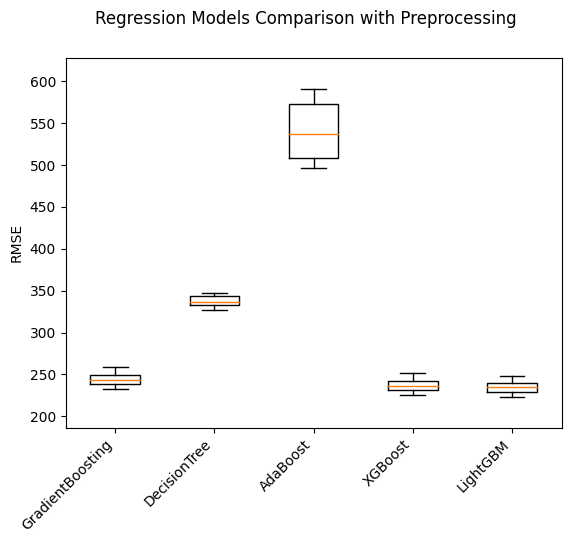

In [10]:
best_model(X_train, y_train)

## Best Performer: LightGBM

In [11]:
lgb_regressor = lgb.LGBMRegressor()

# Train on entire dataset
df = pd.read_csv(df_path)

# Remove data registered after arrival
df = df.drop(['ActualRoute','DepartureActual', 'ArrivalActual', 'BlockTime', 'TaxiOut', 'FlightTime'], axis=1)

# Drop irrelavant columns
df = df.drop(['FlightID', 'FlightNumber', 'AircraftRegistration', 'ServiceDescription', 'Carrier', 'AOCDescription', 'ScheduledRoute',
              'DepartureScheduled', 'ArrivalScheduled'], axis=1)

# Remove negative burnoff
df = df[df["Burnoff"] > 0]

# Split the data into train and test
X = df.drop(labels=['Burnoff'], axis=1)
y = df['Burnoff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('lgbmregressor', lgb_regressor)])

pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"Test R^2: {r2:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 573918, number of used features: 12
[LightGBM] [Info] Start training from score 4630.200713
Test RMSE: 230.89
Test MAE: 166.21
Test R^2: 0.99


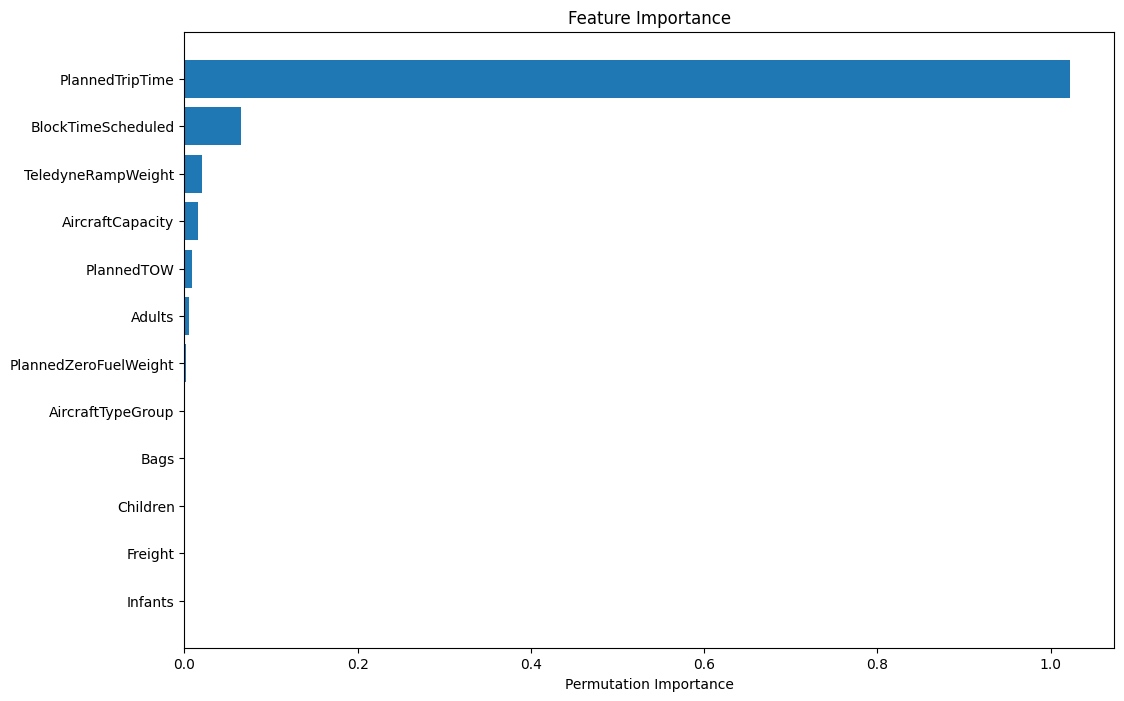

In [12]:
perm_importance = permutation_importance(pipeline, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

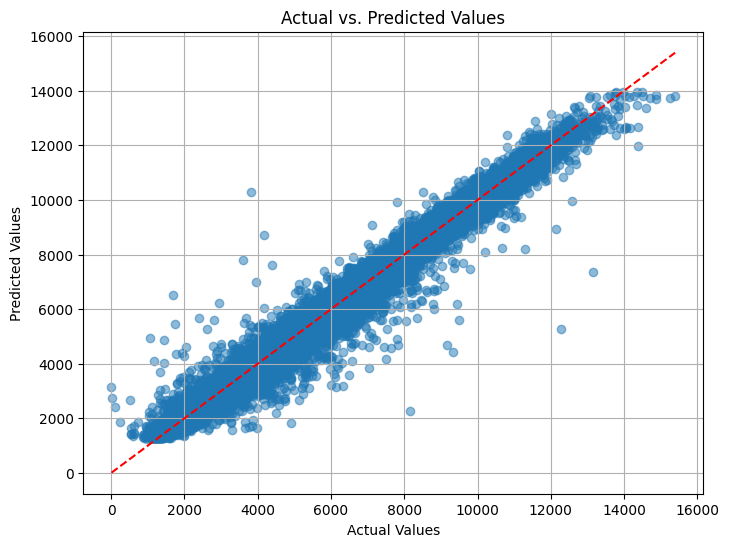

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plotting actual vs. predicted values
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting the identity line for reference
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Red dashed line

plt.grid(True)
plt.show()

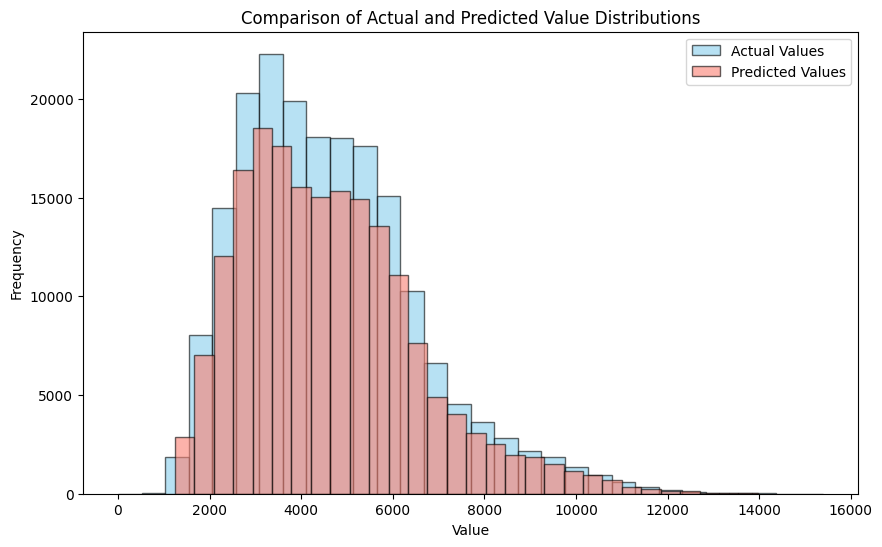

In [14]:
plt.figure(figsize=(10, 6))

plt.hist(y_test, bins=30, alpha=0.6, label='Actual Values', color='skyblue', edgecolor='black')
plt.hist(y_pred, bins=30, alpha=0.6, label='Predicted Values', color='salmon', edgecolor='black')

plt.title('Comparison of Actual and Predicted Value Distributions')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

# Baseline Model with Feature Engineering

In [15]:
# import preprocessed data
df_path = '/content/drive/MyDrive/CapstoneProject/ryanair_clean_datasets/df_fe.csv'
df = pd.read_csv(df_path)

In [16]:
# Drop irrelavant columns
df = df.drop(['FlightID', 'FlightNumber', 'AircraftRegistration', 'ServiceDescription', 'Carrier', 'AOCDescription', 'ScheduledRoute',
              'DepartureScheduled', 'ArrivalScheduled'], axis=1) # Data obtaines after arrival removed in preprocessin

In [17]:
df.columns

Index(['AircraftCapacity', 'AircraftTypeGroup', 'BlockTimeScheduled',
       'Burnoff', 'Adults', 'Children', 'Freight', 'Infants', 'Bags',
       'PlannedZeroFuelWeight', 'PlannedTOW', 'PlannedTripTime',
       'TeledyneRampWeight', 'FuelWeight', 'Distance', 'AircraftAge'],
      dtype='object')

In [18]:
# Reduce dimensions of data due to computing constraints for ensemble models
df = df.tail(100000)

In [19]:
# Split the data into train and test
X = df.drop(labels=['Burnoff'], axis=1)
y = df['Burnoff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [20]:
# Define the preprocessor
categorical_columns = ["AircraftTypeGroup"]
numerical_columns = [col for col in X.columns if col not in categorical_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", OrdinalEncoder(), categorical_columns),
        ("numerical", StandardScaler(), numerical_columns),
    ]
)

In [21]:
def best_model(X_train, Y_train):
    seed = 21
    folds = 10
    metric = 'neg_mean_squared_error'

    models = {
        "GradientBoosting": GradientBoostingRegressor(random_state=seed),
        "DecisionTree": DecisionTreeRegressor(),
        "AdaBoost": AdaBoostRegressor(random_state=seed),
        "XGBoost": XGBRegressor(random_state=seed, verbosity=0),
        "LightGBM": lgb.LGBMRegressor(random_state=seed)
    }


    model_results = []
    model_names = []

    for model_name in models:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', models[model_name])])
        k_fold = KFold(n_splits=folds, random_state=seed, shuffle=True)
        results = cross_val_score(pipeline, X_train, Y_train, cv=k_fold, scoring=metric)
        rmse_results = np.sqrt(-results)

        model_results.append(rmse_results)
        model_names.append(model_name)

        print(f"{model_name:>20}: {rmse_results.mean():.2f} ({rmse_results.std():.2f})")

    figure = plt.figure()
    figure.suptitle('Regression Models Comparison with Preprocessing')
    ax = figure.add_subplot(111)
    plt.boxplot(model_results)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.set_ylabel("RMSE")
    plt.margins(0.05, 0.1)
    plt.show()

    GradientBoosting: 235.58 (7.81)
        DecisionTree: 325.50 (7.68)
            AdaBoost: 489.00 (16.66)
             XGBoost: 224.96 (7.65)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 67500, number of used features: 15
[LightGBM] [Info] Start training from score 4631.692859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2311
[LightGBM] [Info] Number of data points in the train set: 67500, number of used features: 15
[LightGBM] [Info] Start training from score 4626.136415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And

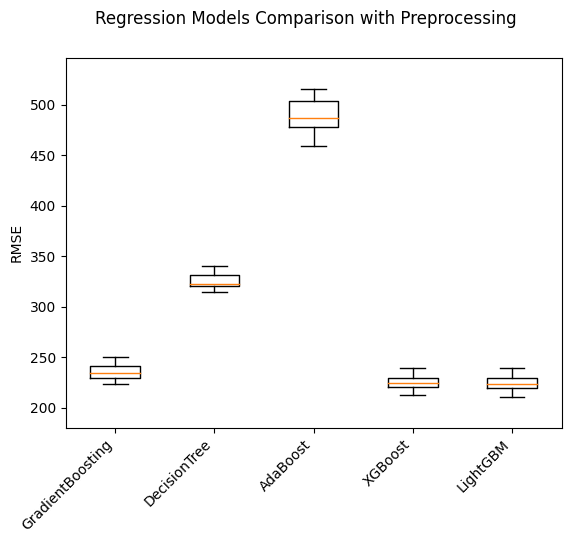

In [22]:
best_model(X_train, y_train)

## Best Performer: LightGBM

In [23]:
lgb_regressor = lgb.LGBMRegressor()

# Train on entire dataset
df = pd.read_csv(df_path)

# Drop irrelavant columns
df = df.drop(['FlightID', 'FlightNumber', 'AircraftRegistration', 'ServiceDescription', 'Carrier', 'AOCDescription', 'ScheduledRoute',
              'DepartureScheduled', 'ArrivalScheduled'], axis=1) # Data obtaines after arrival removed in preprocessin

# Split the data into train and test
X = df.drop(labels=['Burnoff'], axis=1)
y = df['Burnoff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('lgbmregressor', lgb_regressor)])

pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"Test R^2: {r2:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2351
[LightGBM] [Info] Number of data points in the train set: 580993, number of used features: 15
[LightGBM] [Info] Start training from score 4628.678664
Test RMSE: 219.35
Test MAE: 155.95
Test R^2: 0.99


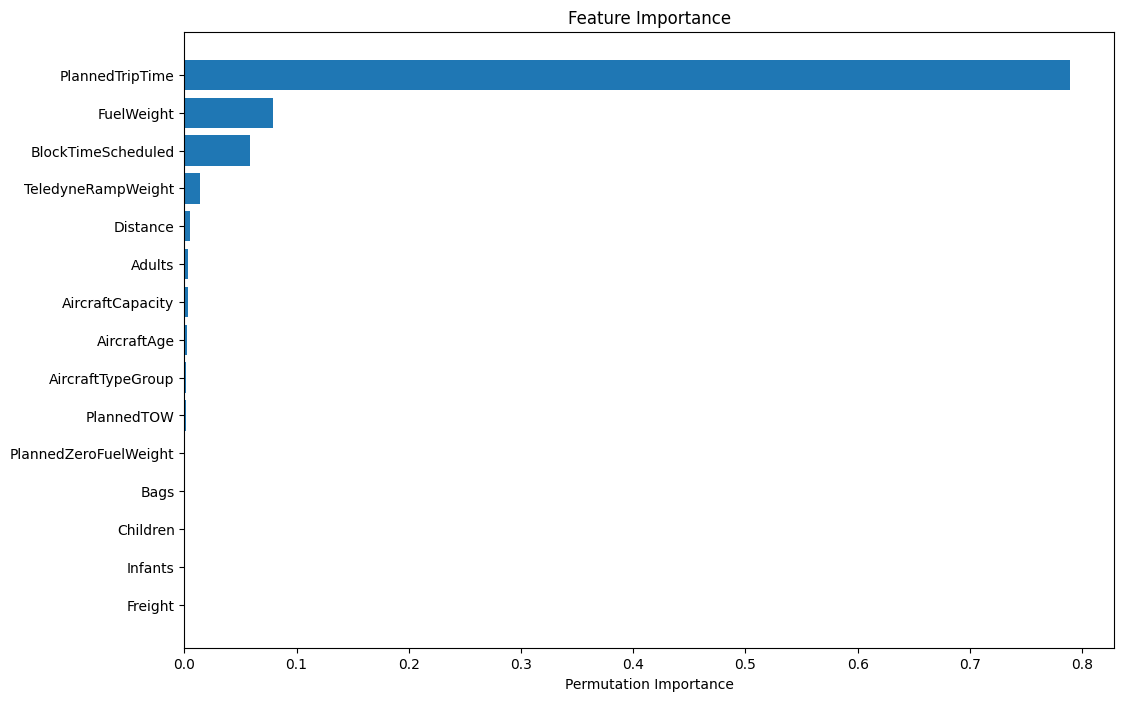

In [24]:
perm_importance = permutation_importance(pipeline, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

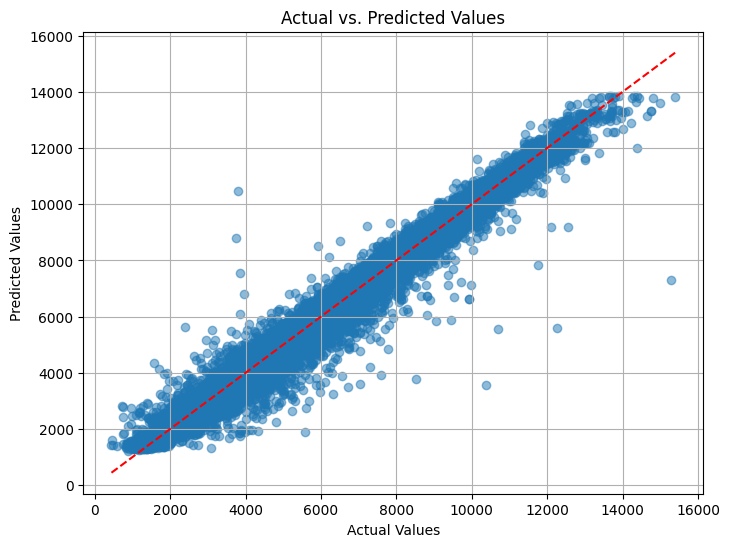

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plotting actual vs. predicted values
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting the identity line for reference
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # Red dashed line

plt.grid(True)
plt.show()

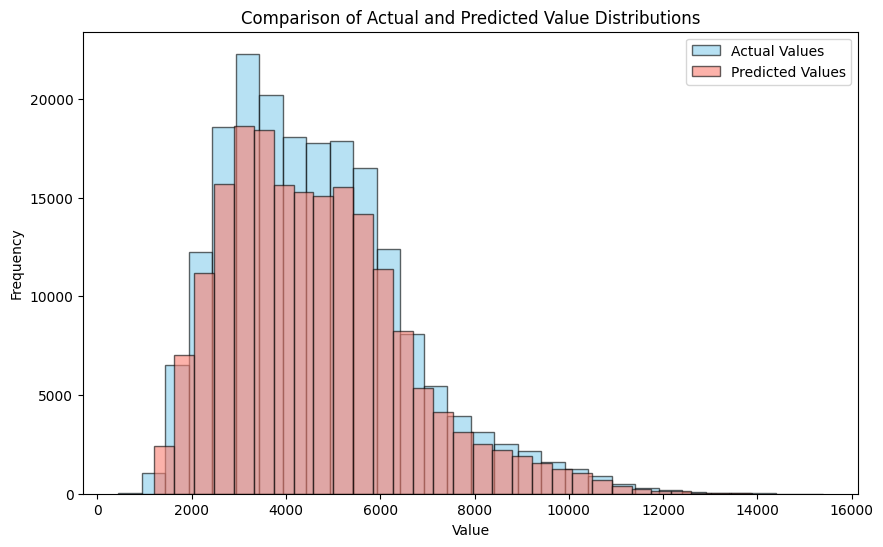

In [26]:
plt.figure(figsize=(10, 6))

plt.hist(y_test, bins=30, alpha=0.6, label='Actual Values', color='skyblue', edgecolor='black')
plt.hist(y_pred, bins=30, alpha=0.6, label='Predicted Values', color='salmon', edgecolor='black')

plt.title('Comparison of Actual and Predicted Value Distributions')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()